In [130]:
import geopandas as gpd

city = 'Boston'
gdf = gpd.read_file(f'data/{city}/pm_trav.shp')
gdf.columns

Index(['lat', 'long', 'time_n', 'speed', 'T_C', 'RH', 'T_F', 'case', 'HI_F',
       'HI_C', 'geometry'],
      dtype='object')

In [71]:
gdf = gdf.to_crs(epsg=3857)
gdf.total_bounds

array([-9780688.53477394,  5107830.43912158, -9743900.59711901,
        5164361.29501909])

In [72]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

In [73]:
coordinates = gdf[['x', 'y']].to_numpy()
print(coordinates)

[[-9754852.20862325  5121780.7325512 ]
 [-9754838.47921938  5121789.43483657]
 [-9754845.15838883  5121829.96272679]
 ...
 [-9764865.48958634  5154071.89647684]
 [-9764900.4624597   5154091.60524417]
 [-9764907.6982266   5154098.9648576 ]]


In [74]:
len(coordinates)

50834

## No need to rasterize!

In [6]:
import rasterio as rio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
# Define the raster grid resolution and extent
resolution = 30  # Cell size in projection units (e.g., meters)
xmin, ymin, xmax, ymax = gdf.total_bounds  # Extent of the shapefile
width = int((xmax - xmin) / resolution)  # Number of columns
height = int((ymax - ymin) / resolution)  # Number of rows
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

# Prepare geometries and temperature values for rasterization
shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['t_f']))

# Rasterize the shapefile
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Fill value for empty cells
    dtype="float32"  # Data type of the raster
)

# Save the rasterized data to a GeoTIFF file
output_tiff_path = f"data/{city}/temp.tif"
with rio.open(
    output_tiff_path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,  # Single band
    dtype="float32",
    crs=gdf.crs,  # Use the CRS from the shapefile
    transform=transform,
) as dst:
    dst.write(raster, 1)  # Write the raster data to band 1

print(f"Raster saved to {output_tiff_path}")

Raster saved to data/Chicago/temp.tif


In [104]:
tif = f"data/{city}/temp.tif"
with rio.open(tif) as src:
    temp = src.read(1)
    bounds = src.bounds
    crs = src.crs

In [8]:
import matplotlib.pyplot as plt

In [105]:
temp.shape

(1884, 1226)

In [106]:
temp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

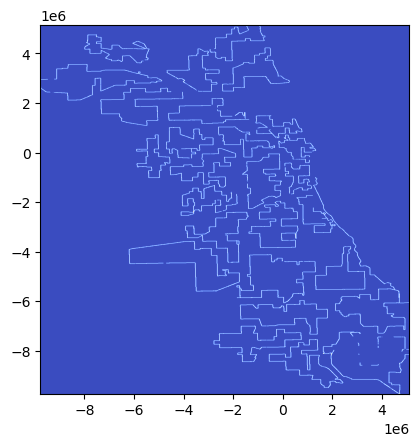

In [107]:
plt.imshow(temp, cmap='coolwarm', extent=bounds)

In [108]:
import numpy as np

# Get the non-zero indices of the temp array
non_zero_indices = np.nonzero(temp)

# Randomly select 15000 indices
random_indices = np.random.choice(len(non_zero_indices[0]), size=15000, replace=False)

# Create a new array of zeros with the same shape as the temp array
reverted_points = np.zeros_like(temp)

# Set the randomly selected non-zero values to the corresponding indices in the new array
reverted_points[non_zero_indices[0][random_indices], non_zero_indices[1][random_indices]] = temp[non_zero_indices[0][random_indices], non_zero_indices[1][random_indices]]

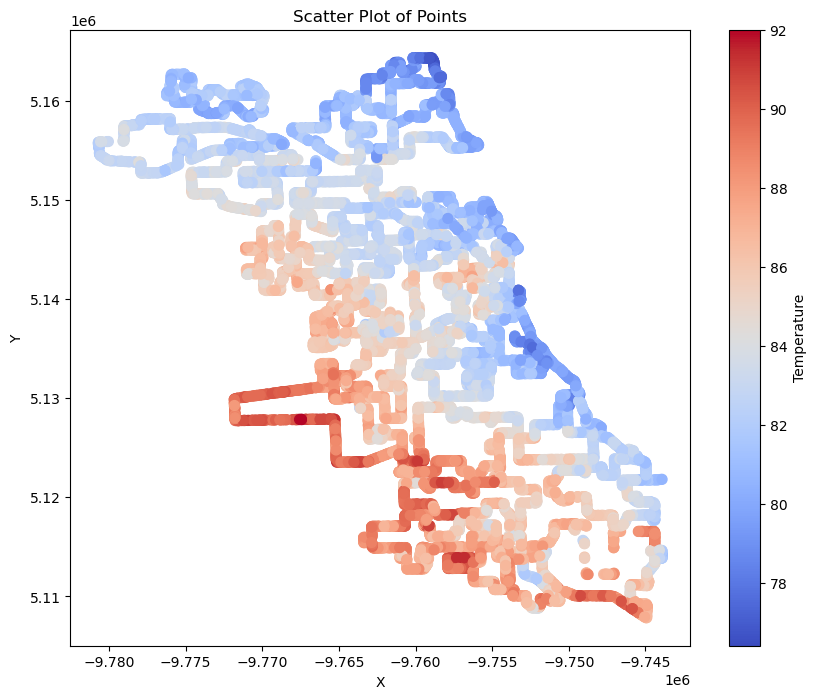

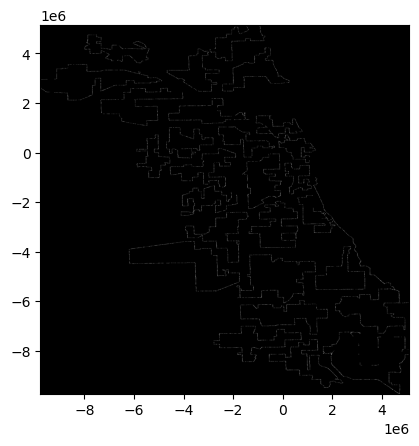

In [112]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50)
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Points')
plt.show()
plt.imshow(reverted_points, cmap='gray', extent=bounds)

In [10]:
from src.utils import (
    load_dataset,
    # rasterize_temp
)
import Datasets

In [11]:
data_dir = f'data/{city}'

In [113]:
data = load_dataset(data_dir, city)

In [114]:
idx = len(data.coords)
idx

27803

In [115]:
y = []

for i in range(idx):
    temp = data[i]
    y.append(temp)

len(y)

27803

In [129]:
import torch
import numpy as np

# X, y = np.array(data.coords), np.array(y)
X, y = coordinates, gdf.T.to_numpy()

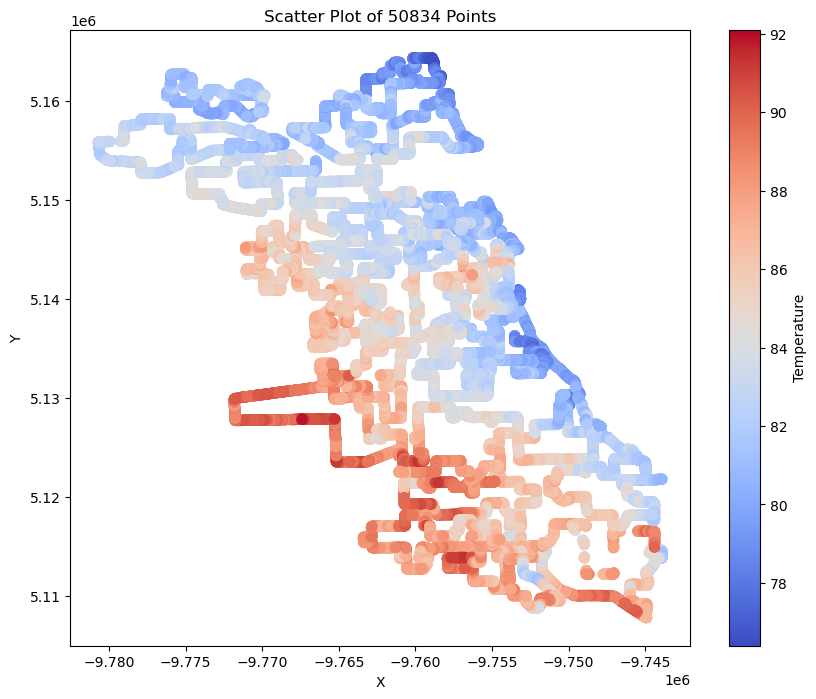

In [125]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50)
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Scatter Plot of {len(X)} Points')
plt.show()

In [126]:
random_indices = np.random.choice(len(X), size=15000, replace=False)
X = X[random_indices]
y = y[random_indices]

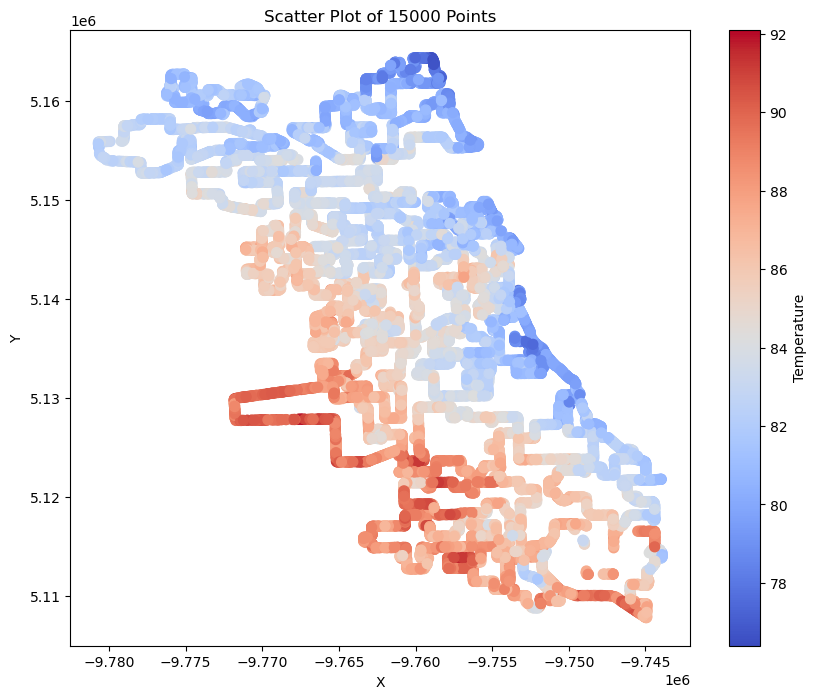

In [127]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50)
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Scatter Plot of {len(X)} Points')
plt.show()

In [91]:
X.shape, y.shape

((15000, 2), (15000,))

In [92]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

In [93]:
y_train

array([-0.24661896, -0.42033343, -0.55930501, ...,  1.94218339,
       -0.42033343,  1.07361103])

# Using GPyTorch

In [94]:
import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Convert the arrays to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [96]:
x_train.shape, y_train.shape

(torch.Size([15000, 2]), torch.Size([15000]))

In [97]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fixed_noise = torch.full_like(y_train, 0.04)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=fixed_noise)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [98]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.326   lengthscale: 0.693
Iter 2/50 - Loss: 1.255   lengthscale: 0.644
Iter 3/50 - Loss: 1.188   lengthscale: 0.598
Iter 4/50 - Loss: 1.124   lengthscale: 0.555
Iter 5/50 - Loss: 1.063   lengthscale: 0.514
Iter 6/50 - Loss: 1.005   lengthscale: 0.475
Iter 7/50 - Loss: 0.949   lengthscale: 0.439
Iter 8/50 - Loss: 0.893   lengthscale: 0.405
Iter 9/50 - Loss: 0.834   lengthscale: 0.373
Iter 10/50 - Loss: 0.770   lengthscale: 0.344
Iter 11/50 - Loss: 0.694   lengthscale: 0.316
Iter 12/50 - Loss: 0.603   lengthscale: 0.289
Iter 13/50 - Loss: 0.497   lengthscale: 0.264
Iter 14/50 - Loss: 0.380   lengthscale: 0.241
Iter 15/50 - Loss: 0.246   lengthscale: 0.219
Iter 16/50 - Loss: 0.102   lengthscale: 0.199
Iter 17/50 - Loss: -0.045   lengthscale: 0.180
Iter 18/50 - Loss: -0.136   lengthscale: 0.163
Iter 19/50 - Loss: -0.217   lengthscale: 0.147
Iter 20/50 - Loss: -0.304   lengthscale: 0.133
Iter 21/50 - Loss: -0.292   lengthscale: 0.120
Iter 22/50 - Loss: -0.271   lengthscal

KeyboardInterrupt: 

In [53]:
original_length_scale = 0.081 * np.mean(x_scale)
original_length_scale

np.float64(125.8335)

In [68]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.387   lengthscale: 0.693
Iter 2/50 - Loss: 1.313   lengthscale: 0.644
Iter 3/50 - Loss: 1.243   lengthscale: 0.598
Iter 4/50 - Loss: 1.176   lengthscale: 0.555
Iter 5/50 - Loss: 1.113   lengthscale: 0.514
Iter 6/50 - Loss: 1.052   lengthscale: 0.475
Iter 7/50 - Loss: 0.993   lengthscale: 0.439
Iter 8/50 - Loss: 0.934   lengthscale: 0.405
Iter 9/50 - Loss: 0.871   lengthscale: 0.373
Iter 10/50 - Loss: 0.806   lengthscale: 0.343
Iter 11/50 - Loss: 0.728   lengthscale: 0.315
Iter 12/50 - Loss: 0.628   lengthscale: 0.289
Iter 13/50 - Loss: 0.522   lengthscale: 0.264
Iter 14/50 - Loss: 0.389   lengthscale: 0.241
Iter 15/50 - Loss: 0.274   lengthscale: 0.219
Iter 16/50 - Loss: 0.110   lengthscale: 0.199
Iter 17/50 - Loss: -0.026   lengthscale: 0.180
Iter 18/50 - Loss: -0.136   lengthscale: 0.162
Iter 19/50 - Loss: -0.254   lengthscale: 0.147
Iter 20/50 - Loss: -0.288   lengthscale: 0.132
Iter 21/50 - Loss: -0.287   lengthscale: 0.120
Iter 22/50 - Loss: -0.301   lengthscal

KeyboardInterrupt: 

In [69]:
original_length_scale = 0.089 * np.mean(x_scale)
original_length_scale

np.float64(138.30599999999998)